In [181]:
import pandas as pd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from tensorflow import keras as k
import numpy as np

In [182]:
#crimes = pd.read_csv("crimes_encoded.csv")
crimes = pd.read_csv("neighborhood_crimes_encoded.csv")

In [183]:
crimes.head()

,neighborhood_code,city_code,estacao,ano,mes,dia,mes_sin,mes_cos,dia_sin,dia_cos,periodo,pontos
0,5215,202,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108011.0
1,683,43,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,107530.0
2,2837,43,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,107529.0
3,4848,305,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108027.0
4,4848,305,1,2020,1,1,0.5,0.866025,0.207912,0.978148,0,108027.0


<AxesSubplot:>

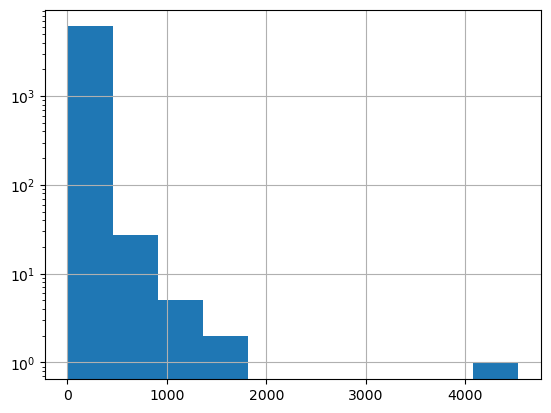

In [184]:
crimes.groupby("neighborhood_code").size().hist(log=True)

In [185]:
X_date = crimes[["estacao", "ano", "mes_sin", "mes_cos", "dia_sin", "dia_cos", "periodo"]].values
X_location = crimes["neighborhood_code"]
X = {"location_code": X_location, "date_features": X_date}

In [186]:
y = crimes["pontos"]
y = y / y.max()

In [187]:
num_locations = crimes["neighborhood_code"].max() + 1
num_locations

6117

In [188]:
k.utils.set_random_seed(42)

In [189]:
location = k.layers.Input(shape=(1,), name="location_code")
date_components = k.layers.Input(shape=(7,), name="date_features")

In [190]:
def embedding_block(input_layer, num_cat, out_dim):
    x = k.layers.Embedding(num_cat, out_dim)(input_layer)
    x = k.layers.Flatten()(x)
    return x

In [191]:
location_embedding = embedding_block(location, num_locations, 5)

In [192]:
normalizer = k.layers.Normalization()
normalizer.adapt(X_date)

In [193]:
time_normalization = normalizer(date_components)
concat_layer = k.layers.concatenate([location_embedding, time_normalization])
hidden_layer = k.layers.Dense(32, activation="relu", name="hidden")(concat_layer)
output_layer = k.layers.Dense(1, activation="sigmoid", name="output")(hidden_layer)

In [194]:
model = k.Model([location, date_components], output_layer)

In [195]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 location_code (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 5)         30585       ['location_code[0][0]']          
                                                                                                  
 date_features (InputLayer)     [(None, 7)]          0           []                               
                                                                                                  
 flatten_5 (Flatten)            (None, 5)            0           ['embedding_5[0][0]']            
                                                                                            

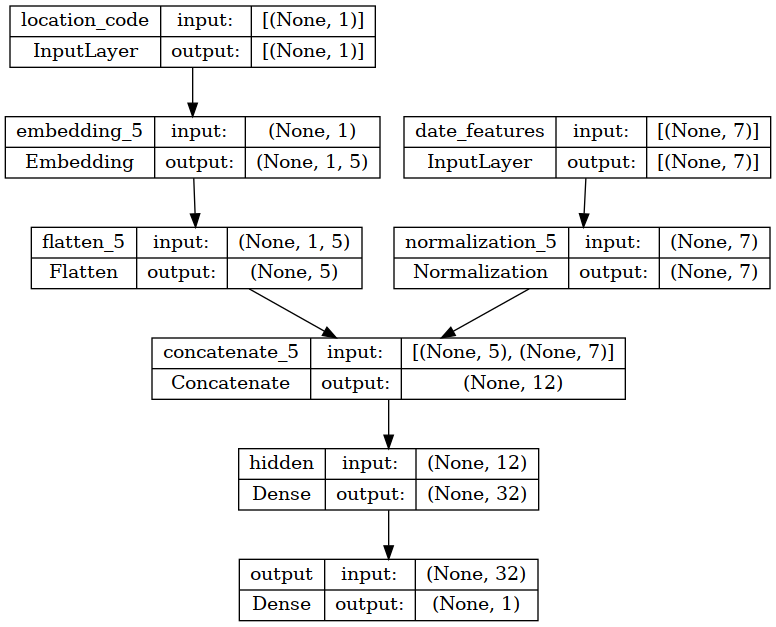

In [196]:
k.utils.plot_model(model, show_shapes=True)

In [197]:
model.compile(optimizer="Adam", loss="mean_absolute_error", metrics=[
    "mean_squared_error",
    "mean_absolute_percentage_error"
    ]
)

In [198]:
model.fit(X, y, batch_size=1_000, epochs=10, validation_split=.2, callbacks=[k.callbacks.TensorBoard()])

Epoch 1/10
99/99 [==============================] - 2s 12ms/step - loss: 0.1494 - mean_squared_error: 0.0363 - mean_absolute_percentage_error: 19.7838 - val_loss: 0.1269 - val_mean_squared_error: 0.0188 - val_mean_absolute_percentage_error: 22.0142
Epoch 2/10
99/99 [==============================] - 1s 9ms/step - loss: 0.0578 - mean_squared_error: 0.0058 - mean_absolute_percentage_error: 8.2216 - val_loss: 0.1164 - val_mean_squared_error: 0.0170 - val_mean_absolute_percentage_error: 19.9812
Epoch 3/10
99/99 [==============================] - 0s 5ms/step - loss: 0.0312 - mean_squared_error: 0.0022 - mean_absolute_percentage_error: 4.4369 - val_loss: 0.0730 - val_mean_squared_error: 0.0075 - val_mean_absolute_percentage_error: 12.3666
Epoch 4/10
99/99 [==============================] - 0s 5ms/step - loss: 0.0214 - mean_squared_error: 0.0012 - mean_absolute_percentage_error: 2.9603 - val_loss: 0.0419 - val_mean_squared_error: 0.0029 - val_mean_absolute_percentage_error: 7.0409
Epoch 5/10


In [199]:
mse, mae, mape = model.evaluate(X, y)
print(f"MSE {mse} | MAE: {mae} | MAPE: {mape}")

  12/3838 [..............................] - ETA: 21s - loss: 0.0126 - mean_squared_error: 6.5726e-04 - mean_absolute_percentage_error: 2.3109

3838/3838 [==============================] - 5s 1ms/step - loss: 0.0135 - mean_squared_error: 7.2948e-04 - mean_absolute_percentage_error: 2.0058
MSE 0.013495322316884995 | MAE: 0.0007294832030311227 | MAPE: 2.0058250427246094


In [200]:
y_pred = model.predict(X)

3838/3838 [==============================] - 5s 1ms/step


(array([  825.,  5521., 11403., 11781., 19302., 19129., 16858., 16342.,
         8361., 13286.]),
 array([0.3713406 , 0.4304464 , 0.48955214, 0.54865795, 0.6077637 ,
        0.66686946, 0.7259753 , 0.785081  , 0.8441868 , 0.9032926 ,
        0.96239835], dtype=float32),
 <BarContainer object of 10 artists>)

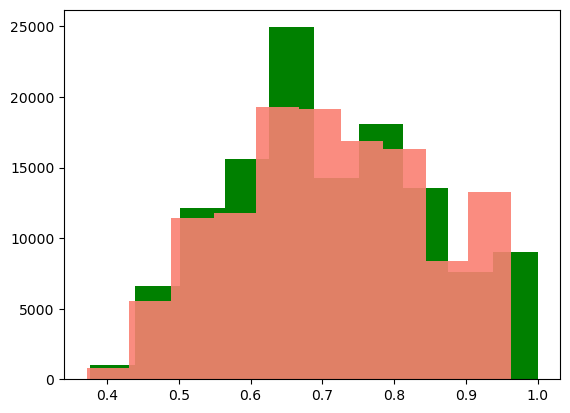

In [201]:
plt.hist(y, color="green")
plt.hist(y_pred, color="salmon", alpha=.9)

In [202]:
crimes["pred"] = y_pred
crimes["score"] = y

<AxesSubplot:xlabel='neighborhood_code'>

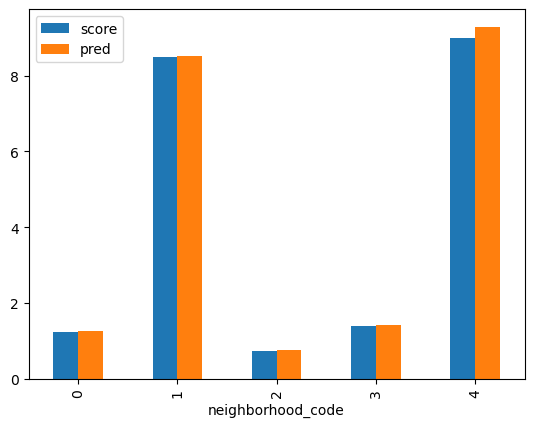

In [203]:
crimes.groupby("neighborhood_code")[["score", "pred"]].sum().head().plot(kind="bar")

<AxesSubplot:xlabel='mes'>

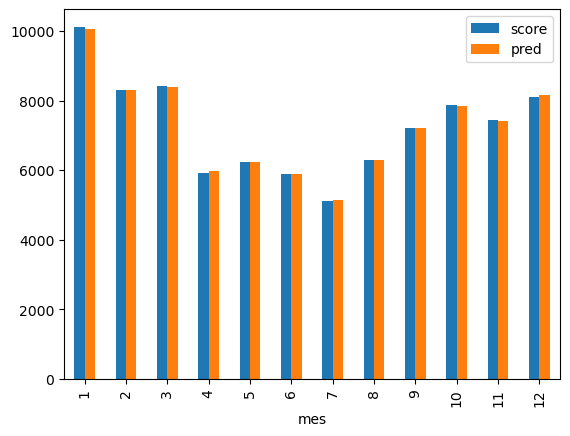

In [204]:
crimes.groupby("mes")[["score", "pred"]].sum().plot(kind="bar")

In [205]:
crimes["abs_error"] = np.absolute(crimes["score"] - crimes["pred"])

In [206]:
crimes.sort_values(by="abs_error", ascending=False).head(30)

,neighborhood_code,city_code,estacao,ano,mes,dia,mes_sin,mes_cos,dia_sin,dia_cos,periodo,pontos,pred,score,abs_error
120764,5910,118,4,2022,9,13,-1.000000e+00,-1.836970e-16,4.067366e-01,-0.913545,0,113244.0,0.800751,0.484937,0.315814
98736,4725,319,4,2022,11,30,-5.000000e-01,8.660254e-01,-2.449294e-16,1.000000,1,127278.0,0.857338,0.545034,0.312304
111297,2143,71,4,2022,11,5,-5.000000e-01,8.660254e-01,8.660254e-01,0.500000,1,127490.0,0.854795,0.545942,0.308854
120590,345,121,3,2022,8,27,-8.660254e-01,-5.000000e-01,-5.877853e-01,0.809017,0,104715.0,0.752896,0.448414,0.304482
120591,345,121,3,2022,8,27,-8.660254e-01,-5.000000e-01,-5.877853e-01,0.809017,0,104715.0,0.752896,0.448414,0.304482
118864,345,121,3,2022,8,27,-8.660254e-01,-5.000000e-01,-5.877853e-01,0.809017,0,104715.0,0.752896,0.448414,0.304482
119064,345,121,3,2022,8,27,-8.660254e-01,-5.000000e-01,-5.877853e-01,0.809017,0,104715.0,0.752896,0.448414,0.304482
120589,345,121,3,2022,8,27,-8.660254e-01,-5.000000e-01,-5.877853e-01,0.809017,0,104715.0,0.752896,0.448414,0.304482
120588,345,121,3,2022,8,27,-8.660254e-01,-5.000000e-01,-5.877853e-01,0.809017,0,104715.0,0.752896,0.448414,0.304482
97774,5913,170,4,2022,11,21,-5.000000e-01,8.660254e-01,-9.510565e-01,-0.309017,0,115647.0,0.798195,0.495227,0.302968


In [207]:
hidden_dense = model.get_layer("hidden")
kernel, bias = hidden_dense.trainable_weights

In [208]:
kernel.numpy().shape

(12, 32)

(array([ 2.,  1.,  5.,  5.,  2., 11.,  5.,  0.,  0.,  1.]),
 array([-0.2250232 , -0.1684199 , -0.11181659, -0.05521329,  0.00139001,
         0.05799332,  0.11459662,  0.17119992,  0.22780322,  0.2844065 ,
         0.34100983], dtype=float32),
 <BarContainer object of 10 artists>)

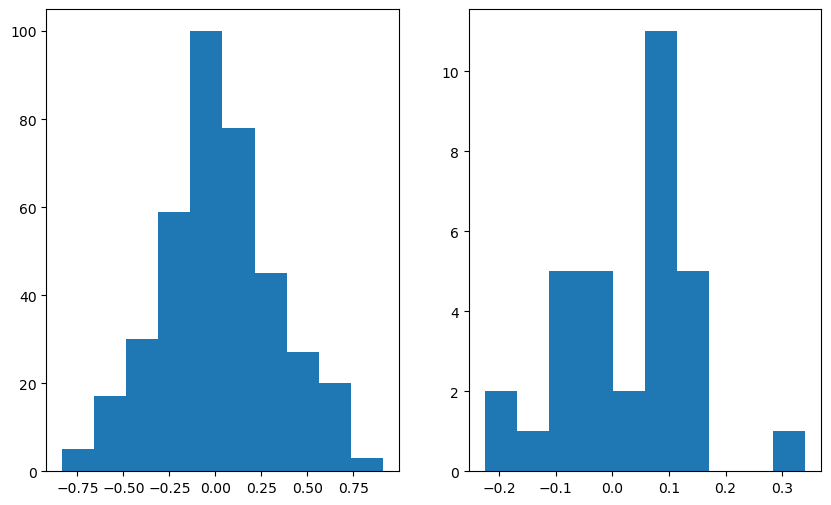

In [209]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(kernel.numpy().ravel())
ax2.hist(bias.numpy())

In [210]:
def sin_transform(x, period):
    return np.sin(x / period * 2 * np.pi)

def cos_transform(x, period):
    return np.cos(x / period * 2 * np.pi)

In [211]:
obs = {"periodo": 1}
start = date(2023, 4, 1)
obs_lst = []
for i in range(365):
    dt = start + timedelta(days=i)
    aux = {
        "ano": dt.year,
        "mes": dt.month,
        "dia": dt.day,
        "estacao": (dt.month % 12) // 3 + 1,
    }
    obs_lst.append(aux)
obs_lst = pd.DataFrame(obs_lst)
obs_lst.loc[:, "mes_sin"] = sin_transform(obs_lst["mes"], 12)
obs_lst.loc[:, "mes_cos"] = cos_transform(obs_lst["mes"], 12)
obs_lst.loc[:, "dia_sin"] = sin_transform(obs_lst["dia"], 30)
obs_lst.loc[:, "dia_cos"] = cos_transform(obs_lst["dia"], 30)
obs_lst["location_code"] = 900
obs_lst["periodo"] = 1
obs_lst = {"location_code": obs_lst["location_code"], "date_features": obs_lst[["estacao", "ano", "mes_sin", "mes_cos", "dia_sin", "dia_cos", "periodo"]]}

In [212]:
forecast_result = model.predict(obs_lst)

12/12 [==============================] - 0s 3ms/step


(array([36., 33., 17.,  4.,  9., 23., 93., 86., 33., 31.]),
 array([0.19792737, 0.21738958, 0.23685181, 0.25631404, 0.27577627,
        0.29523847, 0.3147007 , 0.33416292, 0.35362512, 0.37308735,
        0.39254957], dtype=float32),
 <BarContainer object of 10 artists>)

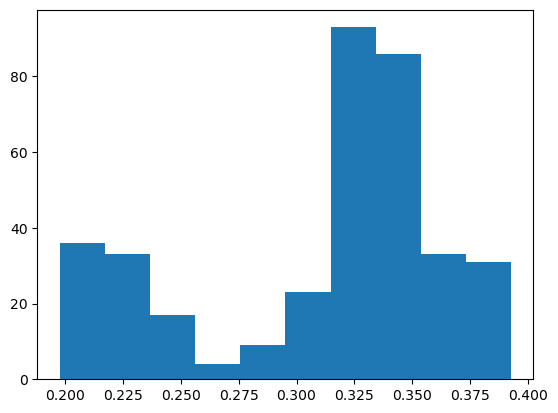

In [213]:
plt.hist(forecast_result)

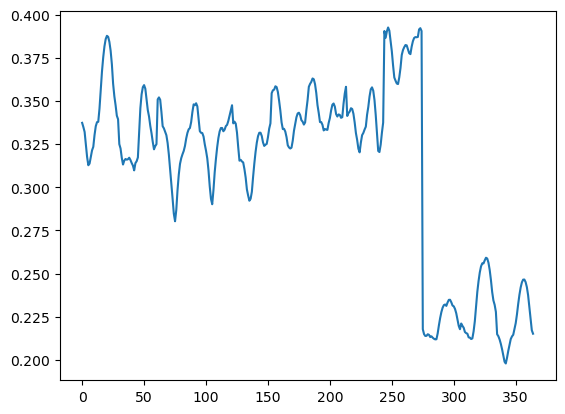

In [214]:
plt.plot(forecast_result)

In [215]:
model.save("../models/score/scoreV2_full")

INFO:tensorflow:Assets written to: ../models/score/scoreV2_full/assets


INFO:tensorflow:Assets written to: ../models/score/scoreV2_full/assets
